# * Prerequisites

You should familiarize yourself with the `numpy.ndarray` class of python's `numpy` library.

You should be able to answer the following questions before starting this assignment. Let's assume `a` is a numpy array.
* What is an array's shape (e.g., what is the meaning of `a.shape`)?  
    * its dimensions
* What is numpy's reshaping operation? 
    * NumPy.reshape, broadcasting
    * How much computational over-head would it induce?  
        * Very little, O(1), constant.Reshaping creates a view, not a copy, only the dimensions are changed. 
* What is numpy's transpose operation, 
    * NumPy.ndarray.transose or ndarray.T
    * How is it different from reshaping? 
        * A transpose flips the row and column of each element. Reshape only changes the dimensions. 
    * Does it cause computation overhead? 
        * No, ie its o(1), constant
* What is the meaning of the commands `a.reshape(-1, 1)` and `a.reshape(-1)`?
    * a.reshape(-1, 1): reshape into column using the number of rows required.
    * a.reshape(-1): flatten the array
* Would happens to the variable `a` after we call `b = a.reshape(-1)`? Does any of `a`'s attributes change?
    * Nothing happens to a
* How do assignments in python and numpy work in general?
        * Names refer to values.
        * Many names can refer to one value.
        * Names are reassigned independently of other names.
        * Values live until nothing references them.
        * Assignment never copies data.
        * Changes in a value are visible through all of its names. (Mutable Presto-Chango)
        * (Source: https://nedbatchelder.com/text/names.html)
    * Does the `b=a` statement use copying by value? Or is it copying by reference? 
        * By reference.
Function context:
"The two most widely known and easy to understand approaches to parameter passing amongst programming languages are pass-by-reference and pass-by-value. Unfortunately, Python is “pass-by-object-reference”, of which it is often said: “Object references are passed by value.”
        * (Source: https://robertheaton.com/2014/02/09/pythons-pass-by-object-reference-as-explained-by-philip-k-dick/.)
        
    * Is the answer to the previous question change depending on whether `a` is a numpy array or a scalar value?
        * No.
    
You can answer all of these questions by: (theoretically, but the documentation is hard to understand and creating the right trials and dummy variables to test this is an order of magnitude more difficult. I prefer to look for 2nd hand explanations that are more comprehensible than the official documentation.)

    1. Reading numpy's documentation from https://numpy.org/doc/stable/.
    2. Making trials using dummy variables.

In [1]:
def reassign(list):
  list = [0, 1]

def append(list):
  list.append(1)

list = [0]
print('list = [0] =>', list)
reassign(list)
print("reassign(list) => ", list)
append(list)
print("append(list) =>", list)

list = [0] => [0]
reassign(list) =>  [0]
append(list) => [0, 1]


In [2]:
listA = [0]
listB = listA
listB.append(1)
print(listA)

[0, 1]


# *Learning Objectives

This assignment's main objective is for you to learn how to utilize matrix operations, and avoid manual calculations as much as possible. 

This objective will have the following benefits:
 1. **Efficiency and Scalability**: Utilizing matrix operations will make your code way more efficient for two reasons:
 
    1.1. **Single Processor Speed-Ups**: Using matrix operations can help your processor plan much better for cache placements, and data fetching. Most numerical computation libraries exploit features of efficient cache usage, SIMD features, etc. This can yield enormous speed-ups using the same computational resources.
    
    1.2. **Multi-Processor Speed-Ups**: Matrix operations are extremely parallelizable. This has a significant impact on hardware acceleration; you could have a parallelizable code without even knowing much about parallelization, as most numerical computation libraries try to automatically exploit as much CPU parallelization as appropriate. 
    
       Furthermore, you could easily use GPU acceleration for the same matrix operations if necessary. On the contrary, it is impractical to convert a python code which was built from scratch using python's default data structures for GPU usage.
       
    1.3. **Spending Less Time Executing High-Level Language Commands and Out-sourcing the Heavy-lifting to Lower-Level Backends**: The high-level languages tend to have expensive commands, as they prioritize coding convinience over efficiency. However, utilizing matrix operations outsources most of the code's heavy-lifting to lower-level languages without the user even knowing about it. For instance, Numpy runs most operations on a pre-compiled C backend. This is also correct about other numerical evaluation libraries such as the automatic-differentiation libraries (e.g., Tensorflow, PyTorch).
    
    
 2. **Portabiliy**: This will make your code smaller, more understandable, and therefore less prone to have bugs. 

# 0. Data

## 0.1 Description

The UC Irvine's Machine Learning Data Repository Department hosts a Kaggle Competition with famous collection of data on whether a patient has diabetes (the Pima Indians dataset), originally owned by the National Institute of Diabetes and Digestive and Kidney Diseases and donated by Vincent Sigillito. 

You can find this data at https://www.kaggle.com/uciml/pima-indians-diabetes-database/data. The Kaggle website offers valuable visualizations of the original data dimensions in its dashboard. It is quite insightful to take the time and make sense of the data using their dashboard before applying any method to the data.

## 0.2 Information Summary

* **Input/Output**: This data has a set of attributes of patients, and a categorical variable telling whether the patient is diabetic or not. 

* **Missing Data**: For several attributes in this data set, a value of 0 may indicate a missing value of the variable.

* **Final Goal**: We want to build a classifier that can predict whether a patient has diabetes or not. To do this, we will train multiple kinds of models, and will be handing the missing data with different approaches for each method (i.e., some methods will ignore their existence, while others may do something about the missing data).

## 0.3 Loading

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from aml_utils import test_case_checker

In [4]:
df = pd.read_csv('../Numpy-lib/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 1. Implementing the Simplest Classifier Ever!

If you look above there is a "Glucose" level variable in the data. Roughly speaking, a healthy person should never have blood Glucose levels of more than 140mg/liter, since a healthy pancreas should be able to control the glucose level by injecting proper amounts of insulin. Physicians use this fact to design the following simple diabetes diagnosis test, which is called the "Oral glucose tolerance test".

* Feed the patient an extremely large amount of fast-acting sugar extract.
* Test the blood glucose level after a couple of minutes.
* If the patient's blood glucose level was less than the 140 mg/liter threshold, then the patient is normal.
* If the patient's blood glucose level was in the 140-199 mg/liter range, then the patient is pre-diabetic.
* If the patient's blood glucose level was more than 200 mg/liter, then the patient is diabetic.

Of course the thresholds are up for debate and research, and this test is not 100% accurate; there are always exceptions and extreme cases. That's why there are many diabetes test types, and we're trying to also build our classifiers which hopefully should be more accurate than this simplistic test. However, this test provides a very simple and memorable way of diabetes assesment and diagnosis.

You can read about these tests at https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451#:~:text=If%20it's%20126%20mg%2FdL,for%20the%20next%20two%20hours..

Let's try and do our own investigation into how accurate this simplistic test can be. This can serve as a baseline for later comparison.

# <span style="color:blue">Task 1 of 6</span>

Write a function ```simple_pred_vec``` that takes a 1-d array of glucose levels $\mathbf{g}$ and a threshold $\theta$ as input, and applies the following prediction rule for patient $i$:
* Predict 1 (i.e., the patient is diabletic) if the patients glucose level $g_i$ is equal or larger than the threshold (i.e. if $g_i\geq \theta$).
* Otherwise predict 0 (i.e., the patient is non-diabetic).

For this task, the input is a 1-d numpy array $g$ with a shape of $(N,)$ and a scalar value $\theta$ (where N is the number of patients). Write your function in a way that the output would have exactly the same shape as the $g$ input including any dummy dimensions of 1. The output data type should be boolean.

**Note**: You do not need to use any reshaping for this task. In other words, do not reshape the $\mathbf{g}$ input and do not try to force an $(N,)$ shape on the output array.

**Note**: There is no necessity of using any for loops in this task. In fact, iterating over the input manually would be an extremely bad itea; it is both inefficient, and has poor coding portability to various shapes. On the other hand, there is a much better one-liner alternative that out-sources all these required comparisons to be done by Numpy, and is even faster.

In [5]:
#parameters: vector of glucose values and a threshold value
#output: boolean array from testing if glucose is above threshold
def simple_pred_vec(g, theta):
    out = (g >= theta)
    return out

In [6]:
# Performing sanity checks on your implementation
assert (simple_pred_vec(g=np.array([100., 200., 140.]), theta=140.) == np.array([False, True, True])).all()

# Checking against the pre-computed test database
test_results = test_case_checker(simple_pred_vec, task_id=1)
assert test_results['passed'], test_results['message']

In [7]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 2 of 6</span>

Using the ```simple_pred_vec``` function that you previously wrote, write a new function ```simple_pred``` function that takes a pandas dataframe ```df``` and threshold ```theta``` as input, and produces a prediction numpy array `pred`.

For this specific task, the `pred` variable will mostly take a shape of $(1, N)$. However, do not force this shape on the `pred` variable by reshaping it to have an exact shape of $(1, N)$; forcing such a shape on the `pred` variable may cause issues when using this function in later tasks.

The dataframe ```df``` has a column ```Glucose``` which indicates the blood glucose levels, and a column ```Outcome``` which indicates whether the patient is diabetic or not. You should extract the `Glucose` column from the dataframe and use it for thresholding and prediction.

* **Hint**: If you like to have the column ```'des_col'``` of a pandas dataframe ```df``` as a numpy array, then ```df['des_col'].values``` may be helpful.

* **Important Note**: The `df['des_col'].values` expression returns a numpy array that is one-dimensional (i.e., has a shape of $(N,)$). In order to maintain portability when possibly utilizing this function in later tasks, it is advised to reshape this `df['des_col'].values` array into having a shape of $(1,N)$ before using it in the `simple_pred` function.

In [8]:
#parameters: data frame and a threshold value
#output: (1, N) boolean array from testing if glucose is above threshold
#theta is (1, N) or scalar 

def simple_pred(df, theta):
    pred = simple_pred_vec(df['Glucose'].values.reshape(1, len(df)), theta)
    return pred


In [9]:
# Performing sanity checks on your implementation
assert np.array_equal(simple_pred(df, 120)[:,:5], np.array([[True, False,  True, False,  True]]))

# Checking against the pre-computed test database
test_results = test_case_checker(simple_pred, task_id=2)
assert test_results['passed'], test_results['message']

In [10]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 3 of 6</span>

Using the ```simple_pred``` function that you previously wrote, write a new function ```simple_acc``` function that takes a pandas dataframe ```df``` and threshold ```theta``` as input, predicts the `Outcome` label, and returns the accuracy `acc` of the predictor.

* In the most trivial case, `theta` can be scalar value (e.g., `theta=120`).

* `theta` can also be a column array (i.e., `theta.shape == (k,1)` where `k` could be any integer). In this case, `acc` should be a vector of accuracy values with the same number of elements as `theta`.

* `acc` should always be a 1-d numpy array (i.e., `acc.shape == (k,)`). Even if `theta` was a scalar value, `acc` should be a numpy array with the shape `(1,)`.

* You can use the exact same way of array extraction (with all the caveats and considerations) from the previous task to extract the `Outcome` column from the `df` dataframe.


**<span style="color:blue">Limitation 1</span>** You should not be using any external libraries or functions for implementing this function. Only numpy functions should be used.

**<span style="color:blue">Limitation 2</span>** You cannot use any loops, such as ```for``` and ```while```, for implementing this function. You should learn how to implement such basic functionalities using numpy's matrix operations and functions.

* **Hint**:  Assume that you have a prediction vector ```pred``` and a label vector ```label``` whose shapes are ```(1,N)```. 

    * Let's have ```a= (pred==label)```. Think about what ```a``` means. 
    * Can you express the prediction accuracy as a numpy function of ```a```?
* you don't need to reshape theta, and just keep it as it is.
* use np.sum(acc, axis=1) / N instead of sum()

* **Hint**: Run the following snippet for yourself, and try and make sense of how each of the variables c, d, e, and f were generated given that a and b had different shapes.


In [11]:
import numpy as np
a = np.array([1,2,3,4]).reshape(1, -1) # "a" is a row vector
b = np.array([1,3,6]).reshape(-1, 1) # "b" is a column vector
c = (a == b)
d = (a * b)
e = (a + b)
f = (a > b)
print(f'c.shape is {c.shape}. d.shape is {d.shape}. e.shape is {e.shape}. f.shape is {f.shape}.')
print('----------')
print('c is ')
print(c)
print('----------')
print('d is ')
print(d)
print('----------')
print('e is ')
print(e)
print('----------')
print('f is ')
print(f)
print('----------')

c.shape is (3, 4). d.shape is (3, 4). e.shape is (3, 4). f.shape is (3, 4).
----------
c is 
[[ True False False False]
 [False False  True False]
 [False False False False]]
----------
d is 
[[ 1  2  3  4]
 [ 3  6  9 12]
 [ 6 12 18 24]]
----------
e is 
[[ 2  3  4  5]
 [ 4  5  6  7]
 [ 7  8  9 10]]
----------
f is 
[[False  True  True  True]
 [False False False  True]
 [False False False False]]
----------


In [12]:
#parameters: df & threshold
#returns: accuracy vector
def simple_acc(df, theta):
    pred = simple_pred(df, theta) # predictions 1,N
    #original:
    #correct = (df['Outcome'].values.reshape(1, len(df)) == pred) #1, N boolean array, 1:accurate 2:error
    #TA
    #label = df['Outcome'].values
    #acc = (label == pred).sum(axis=1) / N
    label = df['Outcome'].values
    #acc =  np.sum(correct, axis = 1)/df.shape[0] #(1,) 
    acc = (label == pred).sum(axis=1) / len(df)

    return acc

In [13]:
# Performing sanity checks on your implementation

# Toy testing the shapes
assert simple_acc(df, theta=120).shape == (1,)
assert simple_acc(df, theta=np.array([50,100,300]).reshape(3,1)).shape == (3,)

# Toy testing the values
assert simple_acc(df, theta=120).round(3)==0.698
assert np.array_equal(simple_acc(df, theta=np.array([[50,100,20,40]]).T).round(3), [0.352, 0.564, 0.35 , 0.35 ])

# Checking against the pre-computed test database
test_results = test_case_checker(simple_acc, task_id=3)
assert test_results['passed'], test_results['message']

In [14]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 4 of 6</span>

Write a function ```best_theta_loopy``` that takes a pandas dataframe ```df```, and uses a ```for``` loop and the function ```simple_acc``` to select the `theta` threshold in the interval $[75,200]$ yielding the highest accuracy.
* Both 75 and 200 should be included in the test.
* Only search for integer `theta` values.

You should produce `best_theta` and `best_accuracy`, where both of them are scalar values.

**Note**: In case multiple thresholds yielded the exact same highest accuracy, `best_theta` should be the smallest threshold among them. In other words, in case multiple optima for `theta` existed within the search range, the tie-breaking rule would be to pick the `theta` with the smallest value as `best_theta`.

In [15]:
#param: pandas dataframe
#return: scalars best_theta and best_accuracy

def best_theta_loopy(df):
    best_accuracy = 0
    best_theta = 75
    for i in np.arange(75, 201):
        ac = simple_acc(df, i)
        acc = ac[0]
        if acc > best_accuracy: # >  and i 75: means we will select the lowest theta that will provide the max
            best_theta = i
            best_accuracy = acc
        else: continue
    return np.array([best_theta, best_accuracy])

In [16]:
# Performing sanity checks on your implementation
assert np.array_equal(best_theta_loopy(df.iloc[:10, :]), np.array((117, 0.9)))

# Checking against the pre-computed test database
test_results = test_case_checker(best_theta_loopy, task_id=4)
assert test_results['passed'], test_results['message']

In [17]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


Now that you have implemented this, let's see what the best threshold would be on the whole data set, and what the resulting accuracy would be.

We did not perform train/test splits, so the accuracy may be inflated a bit...

In [18]:
best_theta, best_acc = tuple(best_theta_loopy(df))
best_theta, best_acc

(144.0, 0.75)

# <span style="color:blue">Task 5 of 6</span>

The use of a for loop in the ```best_theta_loopy``` function is unnecessary; you can re-write the function so that it has the same functionality without using any loops.

Write a function ```best_theta``` that takes a pandas dataframe ```df```, and uses numpy operations to select the theta threshold in the range $[75,200]$ yielding the highest accuracy. You should again produce both `best_theta` and `best_accuracy` scalars.

**Note**: In case multiple thresholds yielded the exact same highest accuracy, `best_theta` should be the smallest threshold among them. In other words, in case multiple optima for `theta` existed within the search range, the tie-breaking rule would be to pick the `theta` with the smallest value as `best_theta`.

**<span style="color:blue">Limitation 1</span>** You should not be using any external libraries or functions for implementing this function. Only numpy functions should be used.

**<span style="color:blue">Limitation 2</span>** You cannot use any loops, such as ```for``` and ```while```, for implementing this function. You should learn how to implement such basic functionalities using numpy's matrix operations and functions.

In [20]:
#argmax to find the right index and then used my simple_acc function to find the accuracy?

def best_theta(df):
    theta = np.arange(75, 201).reshape(-1, 1)
    acc = simple_acc(df, theta)
    i = np.argmax(acc)
    best_theta = theta[i].item()
    #best_accuracy = np.max(acc)
    best_accuracy = acc[i].item()
    return np.array((best_theta, best_accuracy))

In [21]:
# Performing sanity checks on your implementation
assert np.array_equal(best_theta(df.iloc[:10, :]), np.array((117, 0.9)))

# Checking against the pre-computed test database
test_results = test_case_checker(best_theta, task_id=5)
assert test_results['passed'], test_results['message']

In [22]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 6 of 6</span>

Using the ```simple_pred``` function that you previously wrote, write a new function ```simple_confusion``` function that takes a pandas dataframe ```df``` and threshold ```theta``` as input, and produces the confusion matrix $M$, where the rows correspond to the predicted values and the columns correspond to the actual values. 

* `theta` is a scalar value.
* $M$ should have a shape of $(2,2)$ since there are two classes, and the entries should be integer values.

**<span style="color:blue">Limitation 1</span>** You should not be using any external libraries or functions for implementing this function. Only numpy functions should be used.

**<span style="color:blue">Limitation 2</span>** You cannot use any loops, such as ```for``` and ```while```, for implementing this function. You should learn how to implement such basic functionalities using numpy's matrix operations and functions.

In [23]:
np.array([0,1]).reshape(2,1)

array([[0],
       [1]])

In [24]:
np.array([1, 1]).shape

(2,)

In [25]:
( np.array([0,1]).reshape(2,1) == np.array([1, 1]) )

array([[False, False],
       [ True,  True]])

In [26]:
(np.array([0, 1, 1]).reshape(-1,1) == np.array([0, 1]).reshape(1,2)).astype(np.int)

array([[1, 0],
       [0, 1],
       [0, 1]])


*  Review Matrix Multiplication:
https://www.khanacademy.org/math/precalculus/x9e81a4f98389efdf:matrices/x9e81a4f98389efdf:multiplying-matrices-by-matrices/a/multiplying-matrices

* **Hint**: Assume that you have a prediction vector ```pred``` and a label vector ```label``` whose shapes are ```(1,N)```. 
    * Think about what the matrix ```a=(np.array([0,1]).reshape(2,1) == pred).astype(np.int)``` represents. What is its shape?
        * The shape is (2, N)
        * ([[a11 == 11, a11 == b21],  
            [a21 == b11, a21 == b21]]) and so on until bN1  
            ...
          ([[1 == pred1, 1 == pred2, ... 1 == predN]  
            [0 == pred1, 0 == pred2, ... 0 = predN]])  
            
        ***([[Are the predictors True?],  
            [Are the predictors False?]])***  
    * Think about what the matrix ```b=(label.reshape(-1,1) == np.array([0, 1]).reshape(1,2)).astype(np.int)``` represents. What is its shape?  
        * The shape is (N, 2)  
        * [[a11 == b11, a11 == b12],  
           [a21 == b11, a21 == b12],  
           [a31 == b11, a31 == b12]  
            ...  
           [aN1 == b11, aN1 == b1]])  
           
          ([[L1 == 0, L1 == 1],  
            [L2 == 0, L2 == 1],  
           ...
            [LN == 0, LN == 1]])  
            
       ***([[Is label 1 false?, Is label 1 true?]  
            [Is label 2 false?, Is label 2 true?]])***  
    * Think about how you can derive the confusion matrix as a function of ```a``` and ```b```. What matrix operation can be helpful?  
    
**Goal:**  
([[TP, FP],  
  [FN, TN]]) That is counts of:
  
([[L = 1 & P = 1), (L = 0 & P = 1)],  
  [L = 1 & P = 0), (L = 0 & P = 0)]]  
  
***([[(LT & PT), (LF & PT)],  
     [(LT & PF), (LF & PF)]])***  

Summary:  
Given:  
Two rows:  
 a:     ***([[Are the predictors True?],  
             [Are the predictors False?]])***  
              
            AND  
Two columns:            
 b:    ***([[Is label 1 false?, Is label 1 true?]  
            [Is label 2 false?, Is label 2 true?]])***    
            
Want:

c:        ***([[LT & PT), (LF & PT)],  
             [LT & PF), (LF & PF)]])***  
        
        c = [[(b12 = 1 & a11 = 1) + (b22 = 1 & a12 = 1) + .. + (bn2 = 1 & a1n = 1)], [(b11 = 1 & a11 = 1) + (b21 = 1 & a12 = 1) + .. + (bn1 = 1 & a1n = 1)],  
             [(b12 = 1 & a21 = 1) + (b22 = 1 & a22 = 1) + .. + (bn2 = 1 & a2n = 1)], [(b11 = 1 & a21 = 1) + (b21 = 1 & a22 = 1) + .. + (bn1 = 1 & a2n = 1)]])  
        
        c = [[(b1a1) + (b2a1) + .. + (bna1n), (b1a1) + (b2a1) + .. + (bna1n)],  
             [(b1a2) + (b2a2) + .. + (bna2n), (b1a2) + (b2a2) + .. + (bna2n)]])  

        b @ a = b row 1 @ a col 1, b row 1 @ a col 2
                b row 2 @ a col 1, b row 2 @ a col 2) 
          
            c = b@a
               
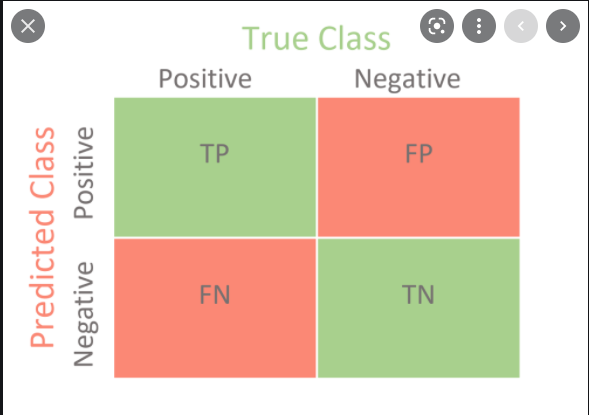

([[TP, FP],  
  [FN, TN]])

In [27]:
theta = 117
simple_pred(df, theta).shape # (1,N)
#df['Outcome'].values.shape #(N,)

(1, 768)

In [28]:
def simple_confusion(df, theta):
    pred = simple_pred(df, theta)
    label = df['Outcome'].values
    a=(np.array([0,1]).reshape(2,1) == pred).astype(np.int)
    b=(label.reshape(-1,1) == np.array([0, 1]).reshape(1,2)).astype(np.int) 
    M = a @ b
    return M

In [29]:
# Performing sanity checks on your implementation
assert np.array_equal(simple_confusion(df.iloc[:100, :], theta=144), np.array([[55, 24], [ 8, 13]]))

# Checking against the pre-computed test database
test_results = test_case_checker(simple_confusion, task_id=6)
assert test_results['passed'], test_results['message']

In [30]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


Let's obtain the confusion matrix and plot the class conditional histograms.

In [31]:
cm = simple_confusion(df, theta=144)
cm

array([[450, 142],
       [ 50, 126]])

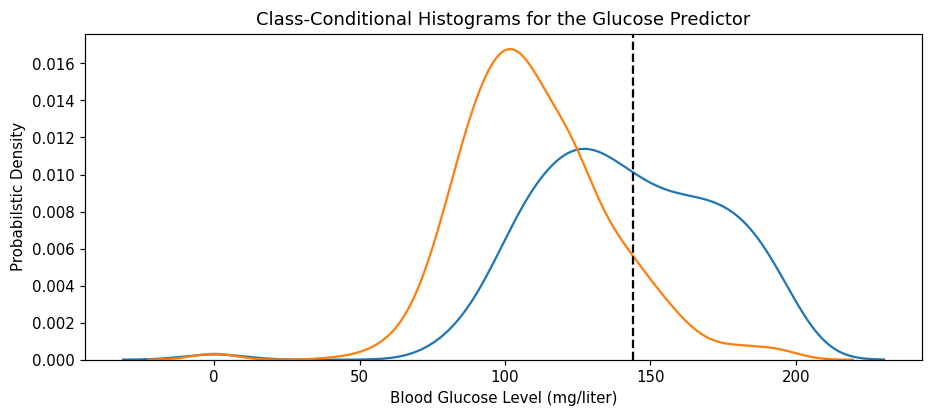

In [32]:
fig, ax = plt.subplots(figsize=(10,4), dpi=108)
sns.kdeplot(df['Glucose'][df['Outcome']==1].values, ax=ax, label='Diabetic Glucose')
sns.kdeplot(df['Glucose'][df['Outcome']==0].values, ax=ax, label='Non-Diabetic Glucose')
ax.set_xlabel('Blood Glucose Level (mg/liter)')
ax.set_ylabel('Probabilstic Density')
ax.set_title('Class-Conditional Histograms for the Glucose Predictor')
_=ax.axvline(x=144, c='black', ls='--')

One question to think about is "why didn't the dashed black separator get placed right at the intersection of the Blue and Orange histograms?".